<a href="https://colab.research.google.com/github/claudio1975/PyDataVenice/blob/main/MLForecast_CP_NVIDIA_eow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Prepare workspace

In [1]:
!pip install mlforecast==1.0.2 &>/dev/null

In [2]:
!pip install yfinance==0.2.65 &>/dev/null

In [3]:
# Yahoo Finance API
# ==============================================================================
import yfinance as yf

In [4]:
# Handling and processing of Data
# ==============================================================================
import numpy as np
import pandas as pd
import scipy.stats as stats

# Handling and processing of Data for Date (time)
# ==============================================================================
import datetime
import time
from datetime import datetime, timedelta
#
# Statistics and Plots
# ==============================================================================
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.diagnostic import normal_ad
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [5]:
# Machine Learning
# ==============================================================================
import xgboost as xgb
from mlforecast import MLForecast
from mlforecast.auto import AutoMLForecast, AutoXGBoost
from mlforecast.lag_transforms import ExpandingMean, ExponentiallyWeightedMean, RollingMean
from mlforecast.target_transforms import Differences
from mlforecast.utils import PredictionIntervals
from sklearn.metrics import mean_squared_error


In [6]:
# Plot
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from utilsforecast.plotting import plot_series
import matplotlib.dates as mdates

In [7]:
# Utils
# ==============================================================================
import re
import warnings
warnings.filterwarnings("ignore")


### Data

In [8]:
stock_ticker = yf.Ticker("NVDA")
stock_history = stock_ticker.history(period="5y")
stock_history.head(10)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-10-26 00:00:00-04:00,13.386138,13.651079,12.998820,13.101257,336896000,0.0,0.0
2020-10-27 00:00:00-04:00,13.265504,13.401091,13.151353,13.355979,250520000,0.0,0.0
2020-10-28 00:00:00-04:00,13.157835,13.219646,12.570628,12.588573,376520000,0.0,0.0
2020-10-29 00:00:00-04:00,12.799427,13.152599,12.711196,12.984363,320080000,0.0,0.0
2020-10-30 00:00:00-04:00,12.810895,12.897131,12.262568,12.495856,416820000,0.0,0.0
2020-11-02 00:00:00-05:00,12.619228,12.797683,12.357278,12.542462,299652000,0.0,0.0
2020-11-03 00:00:00-05:00,12.669825,13.065118,12.564397,12.979878,272900000,0.0,0.0
2020-11-04 00:00:00-05:00,13.348503,13.785420,13.296413,13.752271,410228000,0.0,0.0
2020-11-05 00:00:00-05:00,14.119399,14.295361,13.948421,14.116906,319028000,0.0,0.0


In [9]:
df = stock_history.copy()

# Reset the index
df.reset_index(inplace=True)

# Ensure Date is a datetime object and format it
df['Date'] = pd.to_datetime(df['Date'])

# Select the necessary columns
df = df[['Date', 'Close']]

# Rename the 'Date' column to 'ds'
df = df.rename(columns={'Date': 'ds','Close':'y'})

df["unique_id"] = "1"
df.columns=["ds", "y", "unique_id"]

# Now df should have the index reset, Date formatted, and renamed to 'ds'
df.head()

,ds,y,unique_id
0,2020-10-26 00:00:00-04:00,13.101257,1
1,2020-10-27 00:00:00-04:00,13.355979,1
2,2020-10-28 00:00:00-04:00,12.588573,1
3,2020-10-29 00:00:00-04:00,12.984363,1
4,2020-10-30 00:00:00-04:00,12.495856,1


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1256 entries, 0 to 1255
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype                           
---  ------     --------------  -----                           
 0   ds         1256 non-null   datetime64[ns, America/New_York]
 1   y          1256 non-null   float64                         
 2   unique_id  1256 non-null   object                          
dtypes: datetime64[ns, America/New_York](1), float64(1), object(1)
memory usage: 29.6+ KB


In [11]:
test_size=63

In [12]:
train=df.iloc[:-test_size]
test=df.iloc[-test_size:]


In [13]:
train.shape, test.shape

((1193, 3), (63, 3))

In [14]:
print(train.min())
print(train.max())

ds           2020-10-26 00:00:00-04:00
y                            11.213528
unique_id                            1
dtype: object
ds           2025-07-28 00:00:00-04:00
y                           176.740036
unique_id                            1
dtype: object


In [15]:
print(test.min())
print(test.max())

ds           2025-07-29 00:00:00-04:00
y                            167.01059
unique_id                            1
dtype: object
ds           2025-10-24 00:00:00-04:00
y                           192.570007
unique_id                            1
dtype: object


### Functions

In [16]:
def rename_forecast_columns(df):
    """
    Rename forecast columns to 'y_hat', 'y_hat_lower', and 'y_hat_upper'
    regardless of the estimator name or prediction interval.

    Parameters:
    df (pd.DataFrame): The DataFrame containing forecast results.

    Returns:
    pd.DataFrame: DataFrame with renamed columns.
    """
    new_columns = {}
    for col in df.columns:
        if col == 'y':
            # Keep the actual values column unchanged
            continue
        elif col == 'ds':
            # Keep the actual values column unchanged
            continue
        elif col == 'unique_id':
            # Keep the actual values column unchanged
            continue
        elif re.search(r'-lo-\d+', col):
            # Rename lower prediction interval
            new_columns[col] = 'y_hat_lower'
        elif re.search(r'-hi-\d+', col):
            # Rename upper prediction interval
            new_columns[col] = 'y_hat_upper'
        else:
            # Rename the predicted value
            new_columns[col] = 'y_hat'

    # Apply the renaming
    df = df.rename(columns=new_columns)
    return df

In [17]:
def calculate_rmse(predictions, targets):
    """
    Calculate Root Mean Squared Error between predictions and targets.
    """
    return np.sqrt(mean_squared_error(targets, predictions))

In [18]:
def evaluate_metrics_with_boundaries(df):
    # RMSE for Point Predictions
    rmse = calculate_rmse(df['y_hat'], df['y'])

    # RMSE for Lower Boundary
    rmse_lo = calculate_rmse(df['y_hat_lower'], df['y'])

    # RMSE for Upper Boundary
    rmse_hi = calculate_rmse(df['y_hat_upper'], df['y'])

    # Coverage
    coverage = ((df['y'] >= df['y_hat_lower']) &
                (df['y'] <= df['y_hat_upper'])).mean()

    # Average Width of Prediction Intervals
    average_width = (df['y_hat_upper'] - df['y_hat_lower']).mean()


    metrics = {
        'RMSE_Point': rmse,
        'RMSE_Lower_Bound': rmse_lo,
        'RMSE_Upper_Bound': rmse_hi,
        'Coverage (%)': coverage * 100,
        'Average Width': average_width
    }

    return metrics



In [19]:
def forecast_vis(train, test, prediction, ticker):
  # Reset index to ensure 'ds' is a column
  train_df = train_result.reset_index()
  test_df = test_result.reset_index()
  prediction_df = prediction_result.reset_index()

  # Convert 'ds' to datetime if not already
  train_df['ds'] = pd.to_datetime(train_df['ds'])
  test_df['ds'] = pd.to_datetime(test_df['ds'])
  prediction_df['ds'] = pd.to_datetime(prediction_df['ds'])

  plt.figure(figsize=(16, 8))

  # Plot Training Data
  plt.plot(train_df['ds'], train_df['y'], label='Train Actual', color='black', linewidth=2)

  # Plot Test Data Actual
  plt.plot(test_df['ds'], test_df['y'], label='Test Actual', color='blue', linewidth=2)


  # Plot Test Predictions with PIs
  plt.plot(test_df['ds'], test_df['y_hat'], label='Test Prediction', color='orange', linewidth=2)
  plt.fill_between(test_df['ds'], test_df['y_hat_lower'], test_df['y_hat_upper'],
                 color='orange', alpha=0.2, label='Test Prediction Interval')

  # Plot Future Predictions with PIs
  plt.plot(prediction_df['ds'], prediction_df['y_hat'], label='Future Prediction', color='green', linewidth=2)
  plt.fill_between(prediction_df['ds'], prediction_df['y_hat_lower'], prediction_df['y_hat_upper'],
                 color='green', alpha=0.2, label='Future Prediction Interval')

  # Formatting the plot
  plt.xlabel('Date', fontsize=14)
  plt.ylabel('Value', fontsize=14)
  plt.title(f'Forecasting Results {ticker}', fontsize=16)
  plt.legend(fontsize=12)
  plt.grid(True, which='both', linestyle='--', linewidth=0.5)

  # Improve date formatting on x-axis
  plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
  plt.gca().xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.AutoDateLocator()))

  plt.tight_layout()
  plt.show()

In [20]:
def forecast_vis2(test, prediction, ticker):

  # Reset index to ensure 'ds' is a column (if not already)
  test_df = test_result.reset_index(drop=True)
  prediction_df = prediction_result.reset_index(drop=True)

  # Convert 'ds' to datetime if not already
  test_df['ds'] = pd.to_datetime(test_df['ds'])
  prediction_df['ds'] = pd.to_datetime(prediction_df['ds'])

  # Initialize the plot
  plt.figure(figsize=(16, 8))

  # Plot Test Actual Values
  plt.plot(test_df['ds'], test_df['y'], label='Test Actual', color='blue', linewidth=2)

  # Plot Test Predictions
  plt.plot(test_df['ds'], test_df['y_hat'], label='Test Prediction', color='orange', linewidth=2)

  # Fill PIs for Test Predictions
  plt.fill_between(test_df['ds'], test_df['y_hat_lower'], test_df['y_hat_upper'],
                 color='orange', alpha=0.2, label='Test Prediction Interval')

  # Plot Future Predictions
  plt.plot(prediction_df['ds'], prediction_df['y_hat'], label='Future Prediction', color='green', linewidth=2)

  # Fill PIs for Future Predictions
  plt.fill_between(prediction_df['ds'], prediction_df['y_hat_lower'], prediction_df['y_hat_upper'],
                 color='green', alpha=0.2, label='Future Prediction Interval')

  # Customize the Plot
  plt.xlabel('Date', fontsize=14)
  plt.ylabel('Value', fontsize=14)
  plt.title(f'Test and Future Conformal Prediction Results {ticker}', fontsize=16)
  plt.legend(fontsize=12)
  plt.grid(True, which='both', linestyle='--', linewidth=0.5)

  # Format the x-axis for better readability
  plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
  plt.gca().xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.AutoDateLocator()))

  plt.tight_layout()
  plt.show()

### Modelling

In [21]:
season_length=21
horizon=84
auto_mlf = AutoMLForecast(models={'xgb': AutoXGBoost()}, freq='B', season_length=season_length)


In [22]:
# fit the model on the train set
auto_mlf.fit(train,
             n_windows=3,
             h=horizon,
             num_samples=10,
             fitted=True,
             prediction_intervals=PredictionIntervals(method="conformal_distribution")
             )

[I 2025-10-26 19:17:21,226] A new study created in memory with name: no-name-2eac2837-21de-44f3-8aef-97910eaa6d23
[I 2025-10-26 19:17:24,528] Trial 0 finished with value: 0.06979690290376181 and parameters: {'n_estimators': 558, 'max_depth': 8, 'learning_rate': 0.024376795198947098, 'subsample': 0.5903948646972071, 'colsample_bytree': 0.4812893194050143, 'reg_lambda': 0.0014694435419424668, 'reg_alpha': 3.167361913032263e-05, 'min_child_weight': 10, 'target_transforms_idx': 0, 'lags_idx': 4, 'lag_transforms_idx': 0}. Best is trial 0 with value: 0.06979690290376181.
[I 2025-10-26 19:17:25,851] Trial 1 finished with value: 0.2053835209760039 and parameters: {'n_estimators': 136, 'max_depth': 7, 'learning_rate': 0.002137274057677316, 'subsample': 0.9502020253446255, 'colsample_bytree': 0.5696634895750645, 'reg_lambda': 2.0763258931120774e-05, 'reg_alpha': 1.3075096319371512e-06, 'min_child_weight': 8, 'target_transforms_idx': 6, 'lags_idx': 3, 'lag_transforms_idx': 1}. Best is trial 0 wit

AutoMLForecast(models={'xgb': AutoModel(model=XGBRegressor)})

In [23]:
best_xgb_params = auto_mlf.results_['xgb'].best_trial.user_attrs['config']

print("XGBoost hyperparameters optimized:")
print(best_xgb_params)

XGBoost hyperparameters optimized:
{'model_params': {'n_estimators': 558, 'max_depth': 8, 'learning_rate': 0.024376795198947098, 'subsample': 0.5903948646972071, 'colsample_bytree': 0.4812893194050143, 'reg_lambda': 0.0014694435419424668, 'reg_alpha': 3.167361913032263e-05, 'min_child_weight': 10}, 'mlf_init_params': {'lags': [21, 84], 'target_transforms': None, 'lag_transforms': None, 'date_features': None, 'num_threads': 1}, 'mlf_fit_params': {}}


In [24]:
model1 = [xgb.XGBRegressor(**best_xgb_params,random_state=0)]

mlf = MLForecast(
    models=model1,
    freq='B',
    lags=[1,2],
    target_transforms=[Differences([1])],
    date_features=["year", "month", "day","dayofweek"])




In [25]:
mlf.fit(train,
fitted=True,
prediction_intervals=PredictionIntervals(
n_windows=3,
method="conformal_distribution")
)

MLForecast(models=[XGBRegressor], freq=B, lag_features=['lag1', 'lag2'], date_features=['year', 'month', 'day', 'dayofweek'], num_threads=1)

In [26]:
train_result = mlf.forecast_fitted_values(level=[95])
train_result = train_result.set_index("unique_id")
train_result=rename_forecast_columns(train_result)

In [27]:
# prediction of test set and the next business period
forecast_df = mlf.predict(h=horizon, level=[95])
forecast_df=rename_forecast_columns(forecast_df)
test_max_date = test['ds'].max()
test_forecast = forecast_df[forecast_df['ds'] <= test_max_date]
# Merge the DataFrames on 'unique_id' and 'ds'
test_result = pd.merge(
    test_forecast,
    test,
    on=['unique_id','ds'],
    how='left'
)

# handle missing values
test_result= test_result.dropna()

prediction_result = forecast_df[forecast_df['ds'] > test_max_date]

### Results

In [28]:
# Calculate Metrics
train_metrics = evaluate_metrics_with_boundaries(train_result)

# Display Metrics
print(f"Train metrics:")
for key, value in train_metrics.items():
    print(f"{key}: {value:.4f}")

Train metrics:
RMSE_Point: 0.1963
RMSE_Lower_Bound: 0.4321
RMSE_Upper_Bound: 0.4321
Coverage (%): 93.2773
Average Width: 0.7699


In [29]:
# Calculate Metrics
test_metrics = evaluate_metrics_with_boundaries(test_result)

# Display Metrics
print(f"Test metrics:")
for key, value in test_metrics.items():
    print(f"{key}: {value:.4f}")

Test metrics:
RMSE_Point: 13.5963
RMSE_Lower_Bound: 10.3362
RMSE_Upper_Bound: 17.6467
Coverage (%): 31.7460
Average Width: 9.8515


In [30]:
train_result.head()

,ds,y,y_hat,y_hat_lower,y_hat_upper
unique_id,,,,,
1,2020-10-29 00:00:00-04:00,12.984363,13.035617,12.650664,13.420571
1,2020-10-30 00:00:00-04:00,12.495856,12.504739,12.119786,12.889692
1,2020-11-02 00:00:00-05:00,12.542462,12.505755,12.120802,12.890708
1,2020-11-03 00:00:00-05:00,12.979878,12.899000,12.514047,13.283953
1,2020-11-04 00:00:00-05:00,13.752271,13.721033,13.336079,14.105986


In [31]:
test_result.head()

,unique_id,ds,y_hat,y_hat_lower,y_hat_upper,y
0,1,2025-07-29 00:00:00-04:00,177.333045,172.407275,182.258815,175.500092
1,1,2025-07-30 00:00:00-04:00,175.565419,170.639649,180.491189,179.259903
2,1,2025-07-31 00:00:00-04:00,173.432471,168.506701,178.358241,177.859970
3,1,2025-08-01 00:00:00-04:00,171.756087,166.830317,176.681857,173.710205
4,1,2025-08-04 00:00:00-04:00,173.765788,168.840019,178.691558,179.989853


In [32]:
prediction_result.head()

,unique_id,ds,y_hat,y_hat_lower,y_hat_upper
64,1,2025-10-27 00:00:00-04:00,201.825207,196.899437,206.750977
65,1,2025-10-28 00:00:00-04:00,204.121720,199.195950,209.047490
66,1,2025-10-29 00:00:00-04:00,203.275782,198.350012,208.201552
67,1,2025-10-30 00:00:00-04:00,202.280785,197.355015,207.206555
68,1,2025-10-31 00:00:00-04:00,200.947380,196.021610,205.873150


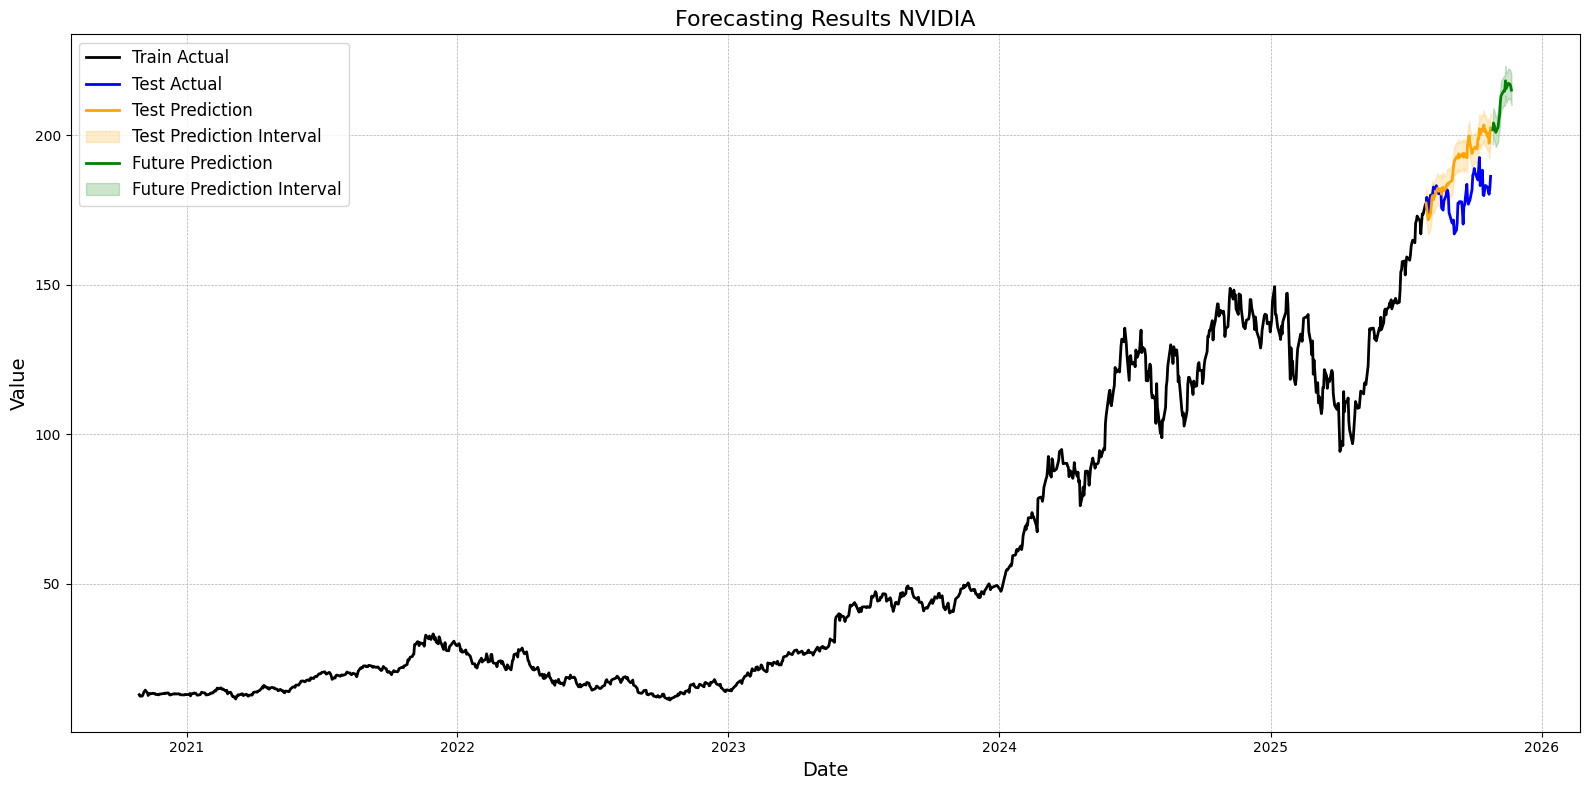

In [33]:
forecast_vis(train_result,test_result,prediction_result, "NVIDIA")

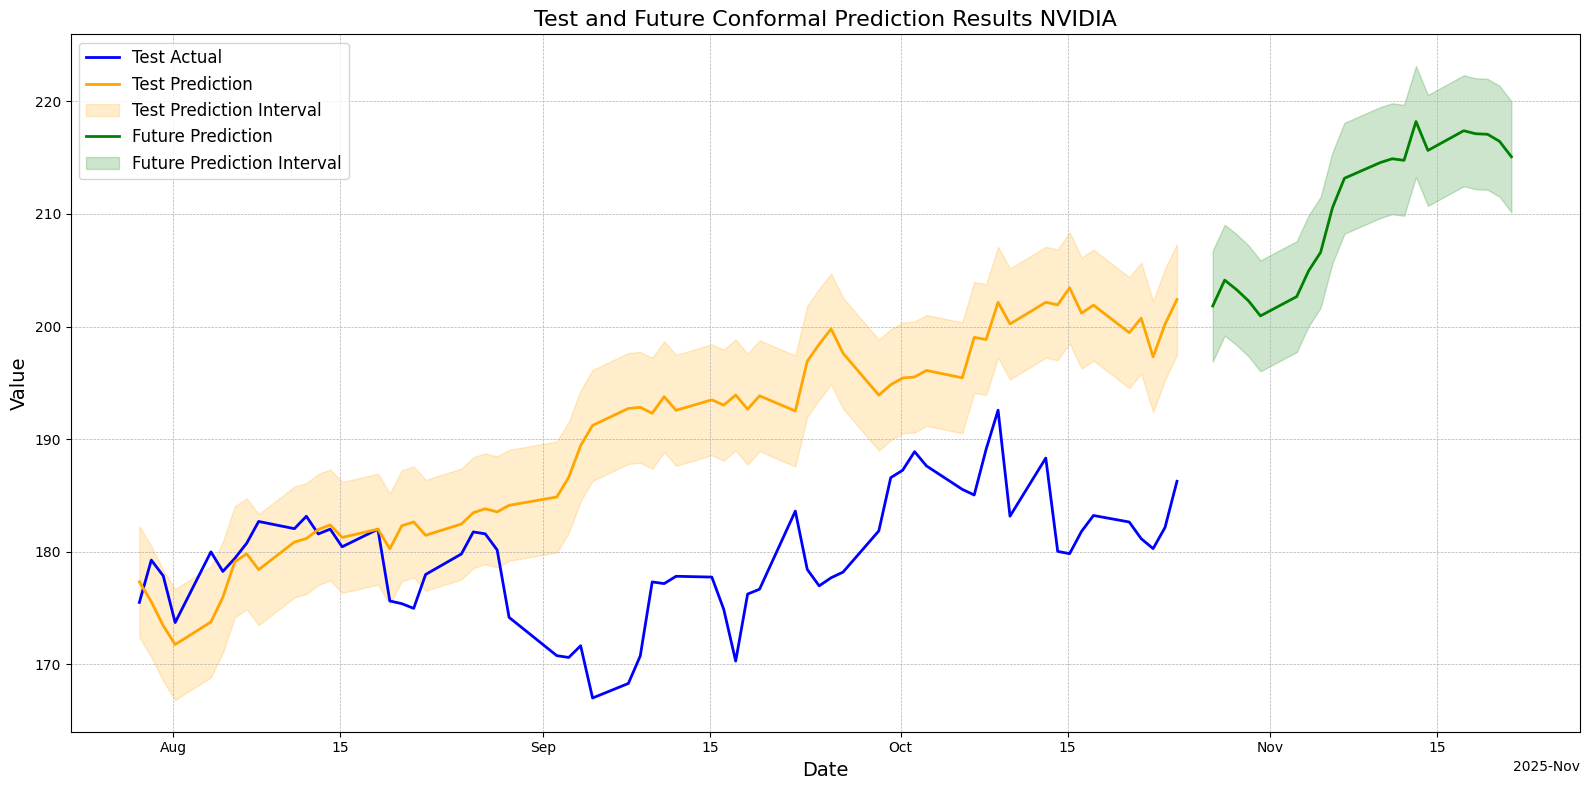

In [34]:
forecast_vis2(test_result, prediction_result,"NVIDIA")

### Prediction Price

In [35]:
actual_price=df.iloc[-1]
forecast_price=prediction_result.iloc[-1]

actual_date = pd.to_datetime(actual_price['ds']).strftime('%d-%m-%Y')
forecast_date = pd.to_datetime(forecast_price['ds']).strftime('%d-%m-%Y')

print(f"At the evaluation date of {actual_date} the stock price is {actual_price['y']}")
print(f"At the forecasting date of {forecast_date} the stock price is {forecast_price['y_hat']}")


At the evaluation date of 24-10-2025 the stock price is 186.25999450683594
At the forecasting date of 21-11-2025 the stock price is 215.07946668937802


### Backtesting

In [36]:
cv= mlf.cross_validation(
    train,
    n_windows=3,
    h=1,
    fitted=True
)
cv_result= mlf.cross_validation_fitted_values()

In [37]:
# Calculate RMSE per fold
rmse_per_fold = cv_result.groupby('fold').apply(lambda x: calculate_rmse(x['y'], x['XGBRegressor']))
rmse_per_fold = rmse_per_fold.rename('RMSE')

# Convert to DataFrame and reset index
rmse_df = rmse_per_fold.reset_index(drop=True).to_frame()

# Add a 'Fold' column
rmse_df['Fold'] = range(0, len(rmse_df))

# Set 'Fold' as the index
rmse_df.set_index('Fold', inplace=True)

# Display the results
print("RMSE per CV Fold:")
print(rmse_df)

# Calculate and display average RMSE across all folds
average_rmse = rmse_df['RMSE'].mean()
print(f"\nAverage CV RMSE across all folds: {average_rmse:.4f}")

RMSE per CV Fold:
          RMSE
Fold          
0     0.183775
1     0.208606
2     0.197710

Average CV RMSE across all folds: 0.1967


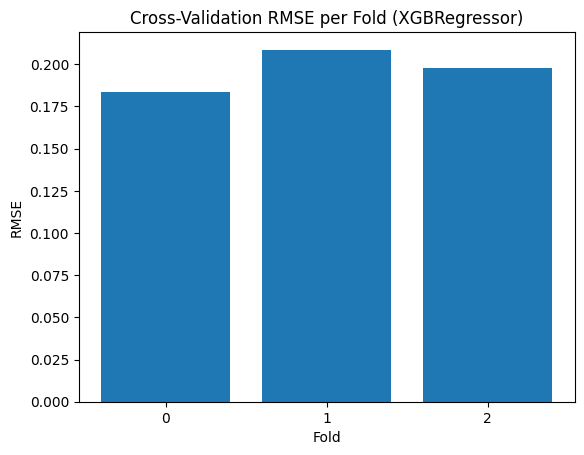

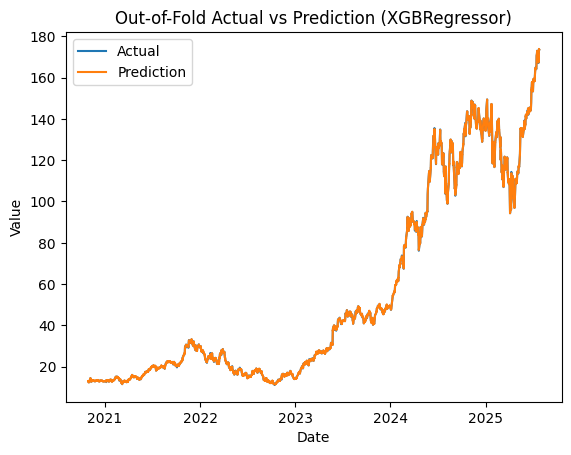

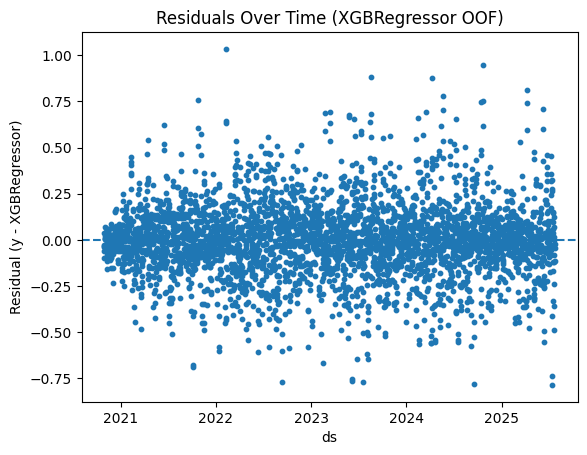

Average CV RMSE across all folds: 0.1967


In [38]:
# === Plots for Cross-Validation Backtesting  ===
# 1) Bar chart of RMSE per fold
# 2) Line plot of Actual vs Prediction over time (OOF)
# 3) Scatter plot of residuals over time


# 1) RMSE per fold (bar chart)

plt.figure()
plt.bar(rmse_df.index.astype(str), rmse_df["RMSE"])
plt.xlabel("Fold")
plt.ylabel("RMSE")
plt.title("Cross-Validation RMSE per Fold (XGBRegressor)")
plt.show()

# 2) Actual vs Prediction over time (line plot)
cv_sorted = cv_result.sort_values(by="ds").reset_index(drop=True)

plt.figure()
plt.plot(cv_sorted["ds"], cv_sorted["y"], label="Actual")
plt.plot(cv_sorted["ds"], cv_sorted["XGBRegressor"], label="Prediction")
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Out-of-Fold Actual vs Prediction (XGBRegressor)")
plt.legend()
plt.show()

# 3) Residuals over time (scatter)
residuals = cv_sorted["y"].astype(float) - cv_sorted["XGBRegressor"].astype(float)

plt.figure()
plt.scatter(cv_sorted["ds"], residuals, s=10)
plt.axhline(0, linestyle="--")
plt.xlabel("ds")
plt.ylabel("Residual (y - XGBRegressor)")
plt.title("Residuals Over Time (XGBRegressor OOF)")
plt.show()

# Print average RMSE
print(f"Average CV RMSE across all folds: {average_rmse:.4f}")


### References

In [39]:
# https://nixtlaverse.nixtla.io/mlforecast/docs/tutorials/prediction_intervals_in_forecasting_models.html
# https://nixtlaverse.nixtla.io/mlforecast/forecast.html